# **Mini-Project 3: Task 3 Question 3**

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# **Getting the normalized dataset:**

In [ ]:
# Get the mean, std of the pixel intensity values
def get_mean_and_std():
  # Get unnormalized data with pixel values [0,1]
  dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
  )

  # Split into 60_000/1_000 = 60 batches for faster processing
  loader = DataLoader(dataset, batch_size=1000, shuffle=False)
  mean, std, num_batches = 0.0, 0.0, 0

  for images, _ in loader:
    batch_samples = images.size(0)

    # Convert 28x28 arrray to 784x1
    images = images.view(batch_samples, -1)

    # Get mean and std for pixel values of the batch
    mean += images.mean(dim=1).sum()
    std += images.std(dim=1).sum()
    num_batches += batch_samples

  mean /= num_batches
  std /= num_batches

  return mean.item(), std.item()

In [ ]:
# Get the train and test datasets loaders
def get_datasets(is_cnn = False):
  # Get the normalization mean and std
  mean, std = get_mean_and_std()

  # Convert and Normalize the data to a tensor (pixel values between 0 and 1) and flatten it to a 784 element list
  ds_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,)),
    transforms.Lambda(lambda x: x.view(-1))
  ])

  # Same as before but keep the 28x28 structure if its a CNN
  if is_cnn:
    ds_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((mean,), (std,)),
    ])

  # Get the transformed train and test datset
  complete_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=ds_transform)
  complete_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=ds_transform)

  train_loader = DataLoader(complete_train_dataset, batch_size=100, shuffle=True)
  test_loader = DataLoader(complete_test_dataset, batch_size=100, shuffle=False)

  return train_loader, test_loader

# **MLP Model Implementation With Regularization**

In [ ]:
#Activation Function
class ReLU:
    def activation(self, x):
        return np.maximum(0, x)

    def derivative(self, x):
        return (x > 0).astype(float)


class Softmax:
    def activation(self, x):
        # x: (batch, num_classes)
        x_shifted = x - np.max(x, axis=1, keepdims=True)  # numerical stability
        exp_x = np.exp(x_shifted)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)




# Loss Function
class MultiClassCrossEntropy:
    def loss(self, pred, true):
        """
        pred: (batch, num_classes) softmax probabilities
        true: (batch, num_classes) one-hot labels
        returns: scalar mean loss over batch
        """
        eps = 1e-12
        pred = np.clip(pred, eps, 1.0 - eps)
        return -np.mean(np.sum(true * np.log(pred), axis=1))



# MLP with L1 / L2 regularization
class MLPBackpropagation:
    def __init__(self,
                 input_size,
                 hidden_sizes,
                 output_size,
                 inner_activation,
                 final_activation,
                 loss_fn,
                 l1_lambda=0.0,
                 l2_lambda=0.0,
                 seed=42):
        """
        input_size: int (e.g. 784 for 28x28 images)
        hidden_sizes: list of ints (e.g. [256, 256])
        output_size: int (10 for FashionMNIST)
        inner_activation: activation object for hidden layers (ReLU)
        final_activation: activation object for output (Softmax)
        loss_fn: loss object (MultiClassCrossEntropy)
        l1_lambda: L1 regularization strength (>= 0)
        l2_lambda: L2 regularization strength (>= 0)
        """
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.inner_fn = inner_activation
        self.outer_fn = final_activation
        self.loss_fn = loss_fn
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

        # Initialize weights: He init for ReLU
        rng = np.random.default_rng(seed)

        layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.W = []
        self.b = []
        for i in range(len(layer_sizes) - 1):
            fan_in = layer_sizes[i]
            fan_out = layer_sizes[i+1]
            W_i = rng.normal(0.0, np.sqrt(2.0 / fan_in), size=(fan_out, fan_in))
            b_i = np.zeros((1, fan_out))
            self.W.append(W_i)
            self.b.append(b_i)

        # will store intermediates during forward pass
        self.zs = []          # pre-activations per layer
        self.activations = [] # activations per layer (including input and output)
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []


    # Forward
    def forward(self, X):
        """
        X: (batch_size, input_size)
        returns: y_pred (batch_size, output_size)
        """
        self.zs = []
        self.activations = [X]

        a = X
        # Hidden layers
        for i in range(len(self.hidden_sizes)):
            z = a @ self.W[i].T + self.b[i]  # (batch, units_i)
            a = self.inner_fn.activation(z)
            self.zs.append(z)
            self.activations.append(a)

        # Output layer
        z_out = a @ self.W[-1].T + self.b[-1]  # (batch, output_size)
        self.zs.append(z_out)
        y_hat = self.outer_fn.activation(z_out)
        self.activations.append(y_hat)

        return y_hat


    # Loss with regularization
    def compute_loss(self, y_pred, y_true):
        """
        Adds L1 and/or L2 regularization to the data loss.
        """
        m = y_true.shape[0]
        data_loss = self.loss_fn.loss(y_pred, y_true)

        reg_loss = 0.0
        if self.l2_lambda > 0.0:
            for W in self.W:
                reg_loss += 0.5 * self.l2_lambda * np.sum(W * W) / m
        if self.l1_lambda > 0.0:
            for W in self.W:
                reg_loss += self.l1_lambda * np.sum(np.abs(W)) / m

        return data_loss + reg_loss



    # Backward (one mini-batch)
    def backward(self, X, y_true, y_pred):
        """
        X: (batch, input_size)
        y_true: (batch, num_classes) one-hot
        y_pred: (batch, num_classes) softmax output
        returns: gradients for W and b
        """
        m = X.shape[0]

        grads_W = [np.zeros_like(W) for W in self.W]
        grads_b = [np.zeros_like(b) for b in self.b]

        # Output layer
        # For softmax + cross-entropy: dL/dz = (y_pred - y_true)
        delta = (y_pred - y_true)  # (batch, output_size)

        # gradient wrt W_L and b_L
        a_prev = self.activations[-2]          # last hidden activation
        grads_W[-1] = (delta.T @ a_prev) / m   # (output_size, units_{L-1})
        grads_b[-1] = np.mean(delta, axis=0, keepdims=True)

        # Hidden layers
        delta_next = delta
        # indices of hidden layers in W: 0..len(hidden_sizes)-1
        for l in reversed(range(len(self.hidden_sizes))):
            W_next = self.W[l+1]  # weights of layer above
            z_l = self.zs[l]      # pre-activation of this hidden layer
            d_relu = self.inner_fn.derivative(z_l)
            delta_hidden = (delta_next @ W_next) * d_relu  # (batch, units_l)

            a_prev = self.activations[l]  # activation of previous layer (input or hidden)
            grads_W[l] = (delta_hidden.T @ a_prev) / m
            grads_b[l] = np.mean(delta_hidden, axis=0, keepdims=True)

            delta_next = delta_hidden

        # Add regularization gradients
        for i in range(len(self.W)):
            if self.l2_lambda > 0.0:
                grads_W[i] += (self.l2_lambda / m) * self.W[i]
            if self.l1_lambda > 0.0:
                grads_W[i] += (self.l1_lambda / m) * np.sign(self.W[i])

        return grads_W, grads_b


    # Parameter update
    def update_params(self, grads_W, grads_b, learning_rate):
        for i in range(len(self.W)):
            self.W[i] -= learning_rate * grads_W[i]
            self.b[i] -= learning_rate * grads_b[i]


    # Training: mini-batch gradient descent
    def fit(self, X, Y, epochs, batch_size, learning_rate,
            X_val=None, Y_val=None, verbose=True):
        """
        X: (N, input_size)
        Y: (N, num_classes) one-hot
        """
        N = X.shape[0]
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        for epoch in range(epochs):
            # shuffle
            indices = np.random.permutation(N)
            X_shuffled = X[indices]
            Y_shuffled = Y[indices]

            # mini-batch loop
            for start in range(0, N, batch_size):
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                Y_batch = Y_shuffled[start:end]

                y_pred_batch = self.forward(X_batch)
                grads_W, grads_b = self.backward(X_batch, Y_batch, y_pred_batch)
                self.update_params(grads_W, grads_b, learning_rate)

            # track losses / accuracies
            y_pred_train = self.forward(X)
            train_loss = self.compute_loss(y_pred_train, Y)
            train_acc = self.evaluate_acc(y_pred_train, Y)
            self.train_loss_history.append(train_loss)
            self.train_acc_history.append(train_acc)

            if X_val is not None and Y_val is not None:
                y_pred_val = self.forward(X_val)
                val_loss = self.compute_loss(y_pred_val, Y_val)
                val_acc = self.evaluate_acc(y_pred_val, Y_val)
                self.val_loss_history.append(val_loss)
                self.val_acc_history.append(val_acc)
                if verbose:
                    print(f"Pass {epoch+1}/{epochs} | "
                          f"train loss: {train_loss:.4f}, train acc: {train_acc:.4f} | "
                          f"val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")
            else:
                if verbose:
                    print(f"Pass {epoch+1}/{epochs} | "
                          f"train loss: {train_loss:.4f}, train acc: {train_acc:.4f}")


    # Prediction & accuracy
    def predict_proba(self, X):
        return self.forward(X)

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def evaluate_acc(self, pred_probs, true_one_hot):
        pred_labels = np.argmax(pred_probs, axis=1)
        true_labels = np.argmax(true_one_hot, axis=1)
        return np.mean(pred_labels == true_labels)

# **Running Experiments**

Train shape: (50000, 784) (50000, 10)
Val shape:   (10000, 784) (10000, 10)
Test shape:  (10000, 784) (10000, 10)

Training config: No regularization
Pass 1/20 | train loss: 0.5092, acc: 0.8203 | val loss: 0.5233, acc: 0.8176 | test loss: 0.5378, acc: 0.8126
Pass 2/20 | train loss: 0.4413, acc: 0.8422 | val loss: 0.4576, acc: 0.8351 | test loss: 0.4821, acc: 0.8225
Pass 3/20 | train loss: 0.4201, acc: 0.8498 | val loss: 0.4396, acc: 0.8419 | test loss: 0.4663, acc: 0.8276
Pass 4/20 | train loss: 0.4013, acc: 0.8555 | val loss: 0.4235, acc: 0.8484 | test loss: 0.4505, acc: 0.8362
Pass 5/20 | train loss: 0.3670, acc: 0.8690 | val loss: 0.3942, acc: 0.8601 | test loss: 0.4228, acc: 0.8474
Pass 6/20 | train loss: 0.3529, acc: 0.8746 | val loss: 0.3820, acc: 0.8614 | test loss: 0.4129, acc: 0.8536
Pass 7/20 | train loss: 0.3454, acc: 0.8759 | val loss: 0.3743, acc: 0.8662 | test loss: 0.4077, acc: 0.8533
Pass 8/20 | train loss: 0.3317, acc: 0.8820 | val loss: 0.3643, acc: 0.8672 | test loss

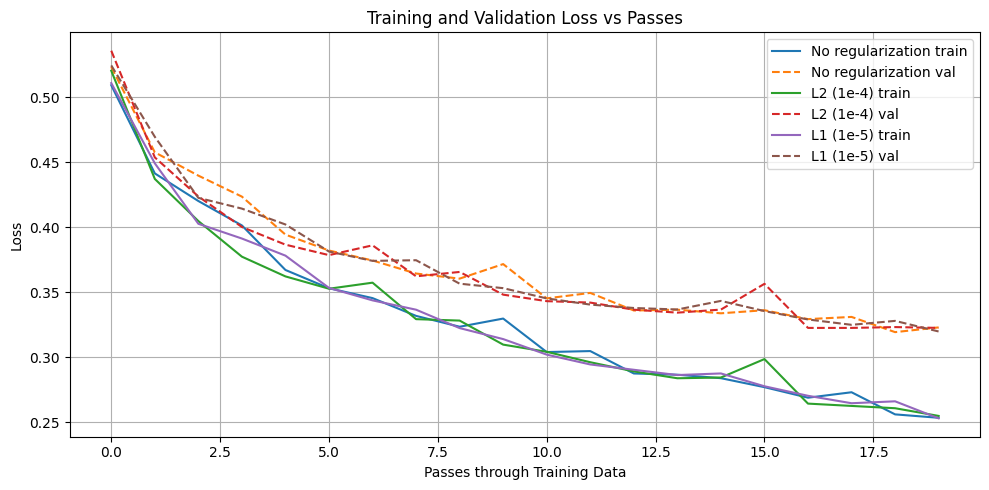

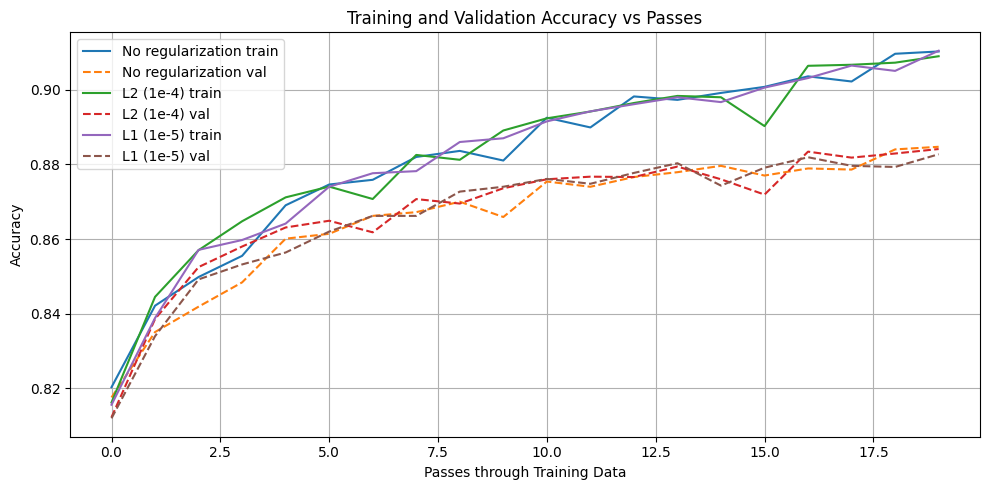

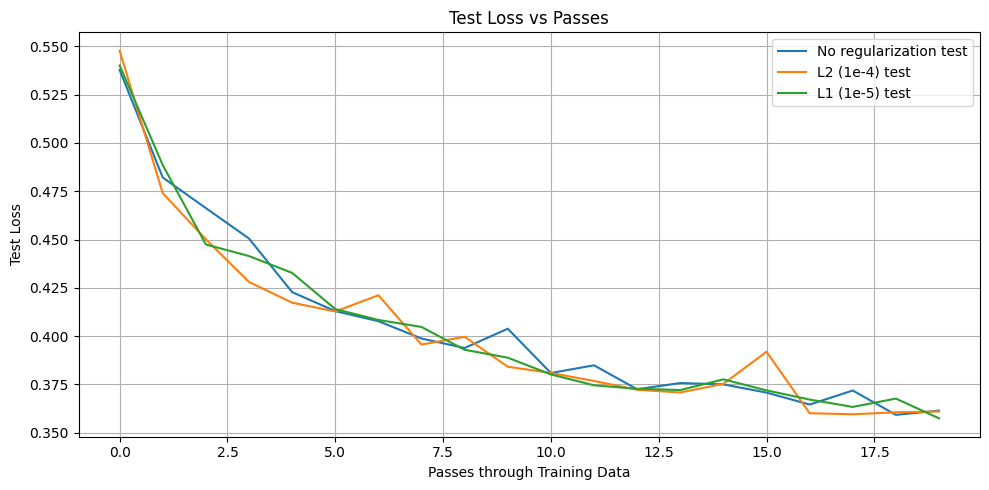

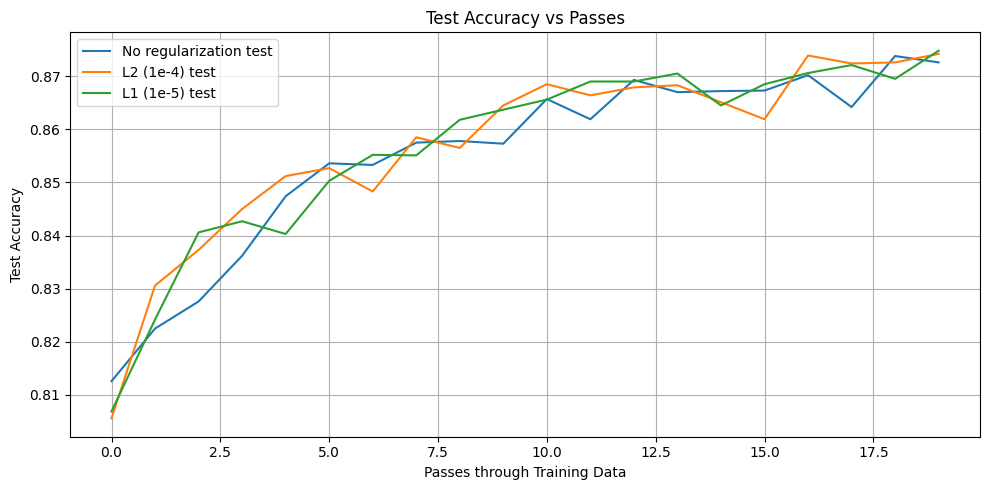

In [ ]:
#  Get data
train_loader, test_loader = get_datasets(is_cnn=False)  # uses your earlier function

def loader_to_numpy(loader):
    X_list, y_list = [], []
    for images, labels in loader:
        # images already flattened and normalized by your transform
        X_list.append(images.numpy())
        y_list.append(labels.numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

X_train_full, y_train_full = loader_to_numpy(train_loader)
X_test, y_test_int = loader_to_numpy(test_loader)

num_classes = 10

def to_one_hot(y, num_classes=10):
    one_hot = np.zeros((y.shape[0], num_classes), dtype=np.float32)
    one_hot[np.arange(y.shape[0]), y] = 1.0
    return one_hot

Y_train_full = to_one_hot(y_train_full, num_classes)
Y_test = to_one_hot(y_test_int, num_classes)


#  Make a train / validation split from the training set
np.random.seed(42)
N = X_train_full.shape[0]
indices = np.random.permutation(N)

val_size = 10000  # e.g. 10k validation samples
val_idx = indices[:val_size]
train_idx = indices[val_size:]

X_train = X_train_full[train_idx]
Y_train = Y_train_full[train_idx]
X_val = X_train_full[val_idx]
Y_val = Y_train_full[val_idx]

print("Train shape:", X_train.shape, Y_train.shape)
print("Val shape:  ", X_val.shape, Y_val.shape)
print("Test shape: ", X_test.shape, Y_test.shape)


# Define experiment configurations (no reg, L2, L1)
configs = [
    {"name": "No regularization", "l1_lambda": 0.0,     "l2_lambda": 0.0},
    {"name": "L2 (1e-4)",         "l1_lambda": 0.0,     "l2_lambda": 1e-4},
    {"name": "L1 (1e-5)",         "l1_lambda": 1e-5,    "l2_lambda": 0.0},
]

input_size = X_train.shape[1]      # 784
hidden_sizes = [256, 256]
output_size = num_classes

epochs = 20
batch_size = 128
learning_rate = 0.01

results = []
trained_models = {}   # will store model + test histories




# Run experiments
for cfg in configs:
    print("\n============================================")
    print(f"Training config: {cfg['name']}")
    print("============================================")

    model = MLPBackpropagation(
        input_size=input_size,
        hidden_sizes=hidden_sizes,
        output_size=output_size,
        inner_activation=ReLU(),
        final_activation=Softmax(),
        loss_fn=MultiClassCrossEntropy(),
        l1_lambda=cfg["l1_lambda"],
        l2_lambda=cfg["l2_lambda"],
        seed=42
    )


    test_loss_history = []
    test_acc_history = []

    N_train = X_train.shape[0]

    for epoch in range(epochs):
        indices = np.random.permutation(N_train)
        X_shuffled = X_train[indices]
        Y_shuffled = Y_train[indices]

        for start in range(0, N_train, batch_size):
            end = start + batch_size
            X_batch = X_shuffled[start:end]
            Y_batch = Y_shuffled[start:end]

            y_pred_batch = model.forward(X_batch)
            grads_W, grads_b = model.backward(X_batch, Y_batch, y_pred_batch)
            model.update_params(grads_W, grads_b, learning_rate)

        # End-of-epoch: train / val metrics
        y_pred_train = model.forward(X_train)
        train_loss = model.compute_loss(y_pred_train, Y_train)
        train_acc = model.evaluate_acc(y_pred_train, Y_train)
        model.train_loss_history.append(train_loss)
        model.train_acc_history.append(train_acc)

        y_pred_val = model.forward(X_val)
        val_loss = model.compute_loss(y_pred_val, Y_val)
        val_acc = model.evaluate_acc(y_pred_val, Y_val)
        model.val_loss_history.append(val_loss)
        model.val_acc_history.append(val_acc)

        # test metrics each epoch
        y_pred_test = model.forward(X_test)
        t_loss = model.compute_loss(y_pred_test, Y_test)
        t_acc = model.evaluate_acc(y_pred_test, Y_test)
        test_loss_history.append(t_loss)
        test_acc_history.append(t_acc)

        print(f"Pass {epoch+1}/{epochs} | "
              f"train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
              f"val loss: {val_loss:.4f}, acc: {val_acc:.4f} | "
              f"test loss: {t_loss:.4f}, acc: {t_acc:.4f}")

    # Final test metrics from last epoch
    final_test_loss = test_loss_history[-1]
    final_test_acc = test_acc_history[-1]

    print(f"Final test loss for {cfg['name']}: {final_test_loss:.4f}")
    print(f"Final test acc  for {cfg['name']}: {final_test_acc:.4f}")

    results.append({
        "name": cfg["name"],
        "l1_lambda": cfg["l1_lambda"],
        "l2_lambda": cfg["l2_lambda"],
        "test_loss": final_test_loss,
        "test_acc": final_test_acc
    })
    trained_models[cfg["name"]] = {
        "model": model,
        "test_loss_history": test_loss_history,
        "test_acc_history": test_acc_history
    }



# Print table summarizing test metrics
print("\n=== Test Performance Summary ===")
print("{:<20} {:>12} {:>12} {:>12} {:>12}".format(
    "Config", "L1 λ", "L2 λ", "Test Loss", "Test Acc"
))
for r in results:
    print("{:<20} {:>12.1e} {:>12.1e} {:>12.4f} {:>12.4f}".format(
        r["name"], r["l1_lambda"], r["l2_lambda"], r["test_loss"], r["test_acc"]
    ))




# Plot training & validation loss vs passes
plt.figure(figsize=(10, 5))
for name, pack in trained_models.items():
    model = pack["model"]
    plt.plot(model.train_loss_history, label=f"{name} train")
    if len(model.val_loss_history) > 0:
        plt.plot(model.val_loss_history, linestyle="--", label=f"{name} val")
plt.title("Training and Validation Loss vs Passes")
plt.xlabel("Passes through Training Data")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot training & validation accuracy vs passes
plt.figure(figsize=(10, 5))
for name, pack in trained_models.items():
    model = pack["model"]
    plt.plot(model.train_acc_history, label=f"{name} train")
    if len(model.val_acc_history) > 0:
        plt.plot(model.val_acc_history, linestyle="--", label=f"{name} val")
plt.title("Training and Validation Accuracy vs Passes")
plt.xlabel("Passes through Training Data")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot test loss vs Passes
plt.figure(figsize=(10, 5))
for name, pack in trained_models.items():
    plt.plot(pack["test_loss_history"], label=f"{name} test")
plt.title("Test Loss vs Passes")
plt.xlabel("Passes through Training Data")
plt.ylabel("Test Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot test accuracy vs Passes
plt.figure(figsize=(10, 5))
for name, pack in trained_models.items():
    plt.plot(pack["test_acc_history"], label=f"{name} test")
plt.title("Test Accuracy vs Passes")
plt.xlabel("Passes through Training Data")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Question 5: Data Augmentation**

# **Preview New Augmented Images**

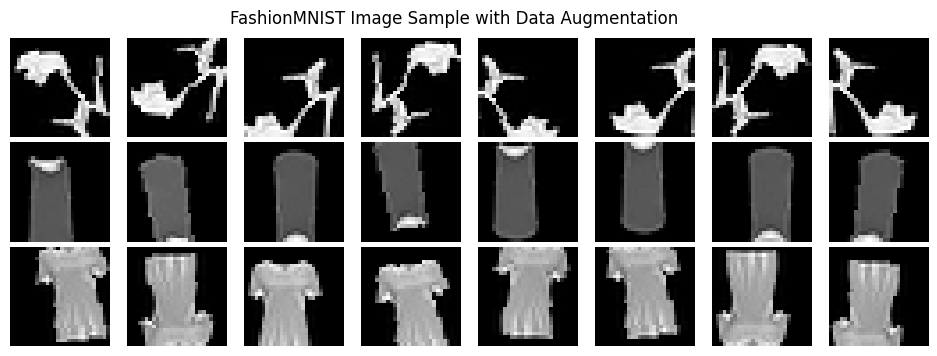

In [ ]:
mean, std = get_mean_and_std()

# Train-time augmentation transform (for the actual model training)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10),                 # small rotation
    transforms.RandomCrop(28, padding=4),          # slight translation via padding+crop
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,)),         # for training
    transforms.Lambda(lambda x: x.view(-1)),       # flatten for MLP (1*28*28 -> 784)
])

# This is what you'll later use as the train transform in your dataset for training:
train_dataset_aug = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)


vis_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),                         # keep as (1, 28, 28) in [0,1]
])

vis_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=vis_transform
)


# Preview a grid of augmented images
plt.figure(figsize=(12, 4))

sample_indices = [9, 2, 10]   # three base images
num_per_row = 8               # 8 augmentations per image
plot_idx = 1

for base_idx in sample_indices:
    for _ in range(num_per_row):
        img, label = vis_dataset[base_idx]  # each access gives a different random augmentation
        plt.subplot(len(sample_indices), num_per_row, plot_idx)
        plt.imshow(img.squeeze().numpy(), cmap='gray')
        plt.axis("off")
        plot_idx += 1

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.suptitle("FashionMNIST Image Sample with Data Augmentation", y=0.95)
plt.show()


# **Run Experiments with this Augmented Data**

Baseline train shape: (50000, 784) (50000, 10)
Augmented train shape: (50000, 784) (50000, 10)
Val shape:             (10000, 784) (10000, 10)
Test shape:            (10000, 784) (10000, 10)

Training: Baseline (no augmentation)
Pass 1/20 | train loss: 0.5164, acc: 0.8144 | val loss: 0.5196, acc: 0.8103 | test loss: 0.5460, acc: 0.8042
Pass 2/20 | train loss: 0.4528, acc: 0.8380 | val loss: 0.4684, acc: 0.8308 | test loss: 0.4919, acc: 0.8208
Pass 3/20 | train loss: 0.4039, acc: 0.8567 | val loss: 0.4237, acc: 0.8449 | test loss: 0.4497, acc: 0.8379
Pass 4/20 | train loss: 0.3749, acc: 0.8673 | val loss: 0.3985, acc: 0.8547 | test loss: 0.4271, acc: 0.8473
Pass 5/20 | train loss: 0.3682, acc: 0.8699 | val loss: 0.3967, acc: 0.8561 | test loss: 0.4245, acc: 0.8482
Pass 6/20 | train loss: 0.3584, acc: 0.8717 | val loss: 0.3885, acc: 0.8566 | test loss: 0.4175, acc: 0.8529
Pass 7/20 | train loss: 0.3347, acc: 0.8805 | val loss: 0.3702, acc: 0.8660 | test loss: 0.3988, acc: 0.8596
Pass 8/2

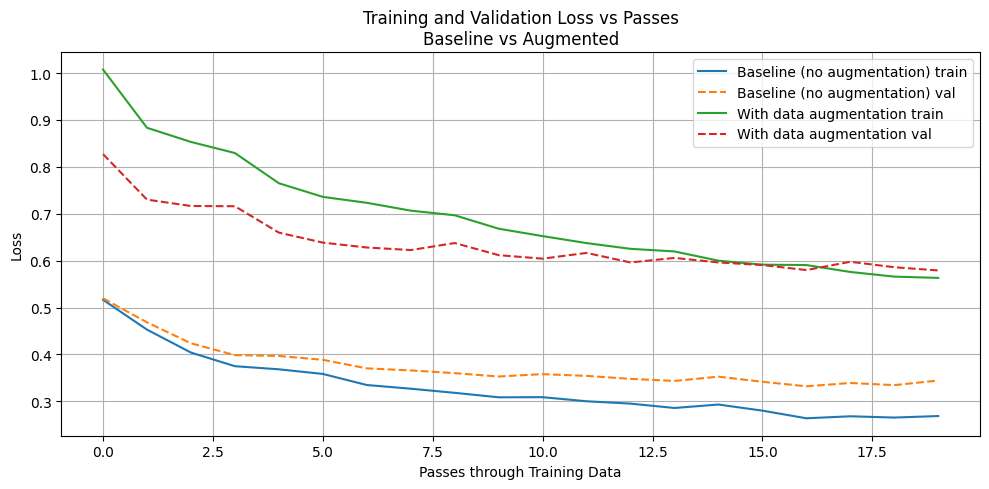

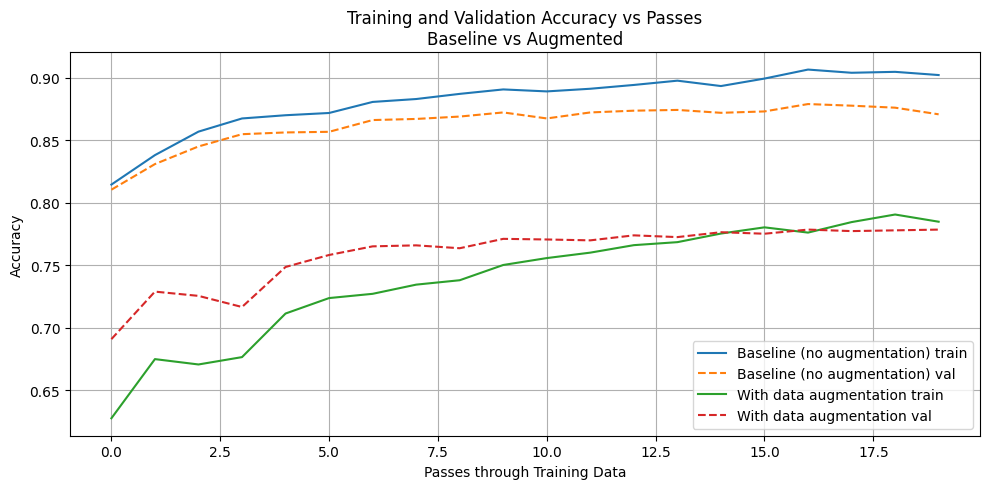

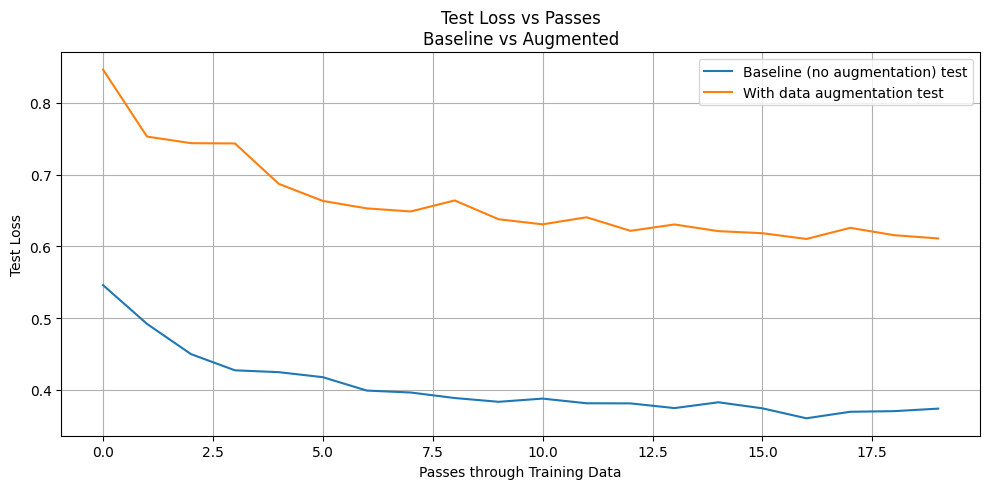

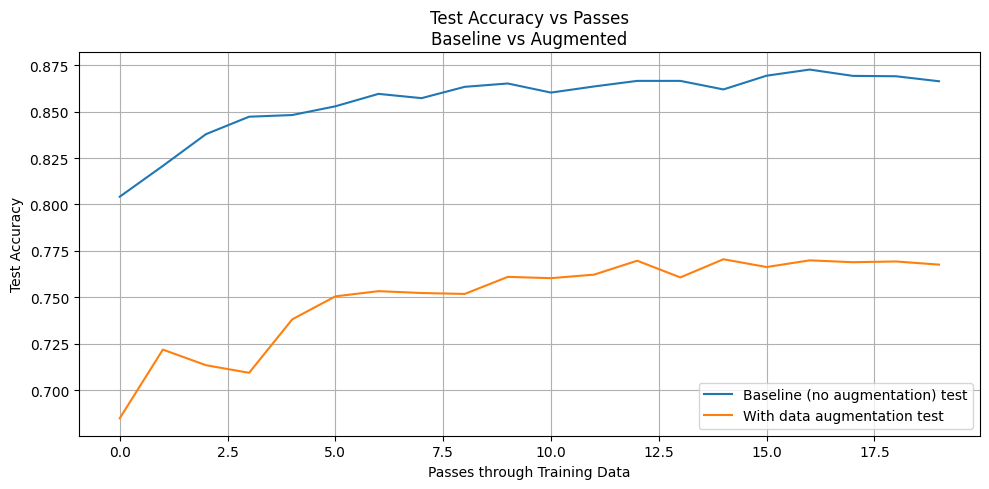

In [ ]:
# Load data
def loader_to_numpy(loader):
    X_list, y_list = [], []
    for images, labels in loader:
        X_list.append(images.numpy())
        y_list.append(labels.numpy())
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

def to_one_hot(y, num_classes=10):
    one_hot = np.zeros((y.shape[0], num_classes), dtype=np.float32)
    one_hot[np.arange(y.shape[0]), y] = 1.0
    return one_hot

num_classes = 10


# Baseline (no augmentation) data
train_loader_base, test_loader = get_datasets(is_cnn=False)  # uses ToTensor+Normalize+Flatten
X_train_full_base, y_train_full = loader_to_numpy(train_loader_base)
X_test, y_test_int = loader_to_numpy(test_loader)

Y_train_full_base = to_one_hot(y_train_full, num_classes)
Y_test = to_one_hot(y_test_int, num_classes)



# Create an augmented training dataset (with same normalization + flatten)
mean, std = get_mean_and_std()

train_transform_aug = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        shear=10,
        scale=(0.8, 1.2)
    ),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,)),
    transforms.Lambda(lambda x: x.view(-1))  # flatten for MLP
])

# Note: test/val should NOT be augmented (we already have test_loader from get_datasets)

aug_train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=train_transform_aug
)

# Here I set shuffle=False because we want the order to match the default dataset index order
aug_train_loader = DataLoader(aug_train_dataset, batch_size=100, shuffle=False)

X_train_full_aug, y_train_full_aug = loader_to_numpy(aug_train_loader)
Y_train_full_aug = to_one_hot(y_train_full_aug, num_classes)



# Train/validation split
np.random.seed(42)
N = X_train_full_base.shape[0]  # 60000
indices = np.random.permutation(N)

val_size = 10000
val_idx = indices[:val_size]
train_idx = indices[val_size:]

# Baseline (no augmentation)
X_train_base = X_train_full_base[train_idx]
Y_train_base = Y_train_full_base[train_idx]
X_val = X_train_full_base[val_idx]      # validation is non-augmented
Y_val = Y_train_full_base[val_idx]

# Augmented
X_train_aug = X_train_full_aug[train_idx]
Y_train_aug = Y_train_full_aug[train_idx]
# Validation remains the same non-augmented X_val, Y_val

print("Baseline train shape:", X_train_base.shape, Y_train_base.shape)
print("Augmented train shape:", X_train_aug.shape, Y_train_aug.shape)
print("Val shape:            ", X_val.shape, Y_val.shape)
print("Test shape:           ", X_test.shape, Y_test.shape)



# Experiment  with configurations (baseline vs augmented)
input_size = X_train_base.shape[1]  # 784
hidden_sizes = [256, 256]
output_size = num_classes

epochs = 20
batch_size = 128
learning_rate = 0.01

experiments = [
    {
        "name": "Baseline (no augmentation)",
        "X_train": X_train_base,
        "Y_train": Y_train_base
    },
    {
        "name": "With data augmentation",
        "X_train": X_train_aug,
        "Y_train": Y_train_aug
    }
]

results = []
trained_models = {}



# Run experiments
for exp in experiments:
    print("\n============================================")
    print(f"Training: {exp['name']}")
    print("============================================")

    model = MLPBackpropagation(
        input_size=input_size,
        hidden_sizes=hidden_sizes,
        output_size=output_size,
        inner_activation=ReLU(),
        final_activation=Softmax(),
        loss_fn=MultiClassCrossEntropy(),
        l1_lambda=0.0,   # you can set these if you want reg as well
        l2_lambda=0.0,
        seed=42
    )

    # Per-epoch test metrics
    test_loss_history = []
    test_acc_history = []

    X_train = exp["X_train"]
    Y_train = exp["Y_train"]
    N_train = X_train.shape[0]

    for epoch in range(epochs):
        # ---- One epoch of mini-batch training ----
        indices = np.random.permutation(N_train)
        X_shuffled = X_train[indices]
        Y_shuffled = Y_train[indices]

        for start in range(0, N_train, batch_size):
            end = start + batch_size
            X_batch = X_shuffled[start:end]
            Y_batch = Y_shuffled[start:end]

            y_pred_batch = model.forward(X_batch)
            grads_W, grads_b = model.backward(X_batch, Y_batch, y_pred_batch)
            model.update_params(grads_W, grads_b, learning_rate)

        # ---- End-of-epoch: train / val metrics ----
        y_pred_train = model.forward(X_train)
        train_loss = model.compute_loss(y_pred_train, Y_train)
        train_acc = model.evaluate_acc(y_pred_train, Y_train)
        model.train_loss_history.append(train_loss)
        model.train_acc_history.append(train_acc)

        y_pred_val = model.forward(X_val)
        val_loss = model.compute_loss(y_pred_val, Y_val)
        val_acc = model.evaluate_acc(y_pred_val, Y_val)
        model.val_loss_history.append(val_loss)
        model.val_acc_history.append(val_acc)

        # ---- NEW: test metrics each epoch ----
        y_pred_test = model.forward(X_test)
        t_loss = model.compute_loss(y_pred_test, Y_test)
        t_acc = model.evaluate_acc(y_pred_test, Y_test)
        test_loss_history.append(t_loss)
        test_acc_history.append(t_acc)

        print(f"Pass {epoch+1}/{epochs} | "
              f"train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
              f"val loss: {val_loss:.4f}, acc: {val_acc:.4f} | "
              f"test loss: {t_loss:.4f}, acc: {t_acc:.4f}")

    # Final test metrics from last epoch
    final_test_loss = test_loss_history[-1]
    final_test_acc = test_acc_history[-1]

    print(f"Final test loss for {exp['name']}: {final_test_loss:.4f}")
    print(f"Final test acc  for {exp['name']}: {final_test_acc:.4f}")

    results.append({
        "name": exp["name"],
        "test_loss": final_test_loss,
        "test_acc": final_test_acc
    })
    trained_models[exp["name"]] = {
        "model": model,
        "test_loss_history": test_loss_history,
        "test_acc_history": test_acc_history
    }



# Print a comparison table
print("\n=== Test Performance Comparison (Baseline vs Augmented) ===")
print("{:<30} {:>12} {:>12}".format("Config", "Test Loss", "Test Acc"))
for r in results:
    print("{:<30} {:>12.4f} {:>12.4f}".format(r["name"], r["test_loss"], r["test_acc"]))



# Plot training & validation curves
plt.figure(figsize=(10, 5))
for name, pack in trained_models.items():
    model = pack["model"]
    plt.plot(model.train_loss_history, label=f"{name} train")
    if len(model.val_loss_history) > 0:
        plt.plot(model.val_loss_history, linestyle="--", label=f"{name} val")
plt.title("Training and Validation Loss vs Passes\nBaseline vs Augmented")
plt.xlabel("Passes through Training Data")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for name, pack in trained_models.items():
    model = pack["model"]
    plt.plot(model.train_acc_history, label=f"{name} train")
    if len(model.val_acc_history) > 0:
        plt.plot(model.val_acc_history, linestyle="--", label=f"{name} val")
plt.title("Training and Validation Accuracy vs Passes\nBaseline vs Augmented")
plt.xlabel("Passes through Training Data")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot test loss and accuracy vs passes
plt.figure(figsize=(10, 5))
for name, pack in trained_models.items():
    plt.plot(pack["test_loss_history"], label=f"{name} test")
plt.title("Test Loss vs Passes\nBaseline vs Augmented")
plt.xlabel("Passes through Training Data")
plt.ylabel("Test Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for name, pack in trained_models.items():
    plt.plot(pack["test_acc_history"], label=f"{name} test")
plt.title("Test Accuracy vs Passes\nBaseline vs Augmented")
plt.xlabel("Passes through Training Data")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()